In [1]:
%reload_ext autoreload
%autoreload 2

In [4]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
from ripple_heterogeneity.readout import readout_explained_var
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## get sessions with pfc or mec

In [3]:
from ripple_heterogeneity.readout import readout_explained_var

df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
cell_metrics = loading.load_all_cell_metrics(df.basepath)

sessions = pd.DataFrame()
sessions["basepath"] = cell_metrics[
    cell_metrics.brainRegion.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")
].basepath.unique()

In [18]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr"
)

ev_df, pairwise_corr_df = readout_explained_var.load_results(save_path)
pairwise_corr_df["corrcoef"] = pairwise_corr_df["corr"] 
pairwise_corr_df = pairwise_corr_df.drop(["corr"], axis=1)

In [19]:
pairwise_corr_df

,epoch,region,sublayer,basepath,corrcoef
0,pre,EC1|EC2|EC3|EC4|EC5|MEC,Deep,Z:\Data\AYAold\AYA7\day19,NaN
1,pre,EC1|EC2|EC3|EC4|EC5|MEC,Deep,Z:\Data\AYAold\AYA7\day19,NaN
2,pre,EC1|EC2|EC3|EC4|EC5|MEC,Deep,Z:\Data\AYAold\AYA7\day19,NaN
3,pre,EC1|EC2|EC3|EC4|EC5|MEC,Deep,Z:\Data\AYAold\AYA7\day19,NaN
4,pre,EC1|EC2|EC3|EC4|EC5|MEC,Deep,Z:\Data\AYAold\AYA7\day19,NaN
...,...,...,...,...,...
2640631,post,PFC,Deep,Z:\Data\ORproject\OR18\day2,NaN
2640632,post,PFC,Deep,Z:\Data\ORproject\OR18\day2,NaN
2640633,post,PFC,Deep,Z:\Data\ORproject\OR18\day2,NaN
2640634,post,PFC,Deep,Z:\Data\ORproject\OR18\day2,NaN


<AxesSubplot:xlabel='epoch', ylabel='corrcoef'>

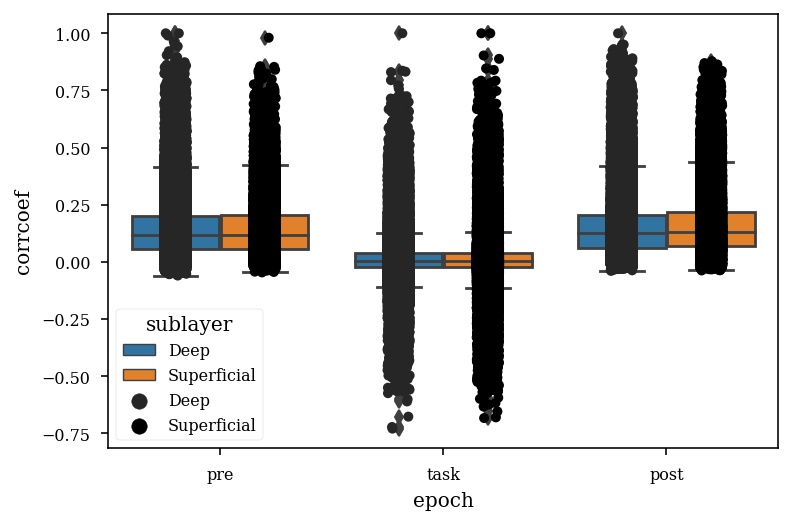

In [23]:
sns.boxplot(x="epoch", y="corrcoef",hue="sublayer", data=pairwise_corr_df)
sns.stripplot(x="epoch", y="corrcoef",hue="sublayer", data=pairwise_corr_df,dodge=True,color='k')